In [3]:
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.losses import Loss
from cal_error import ExpectedCalibrationError
import time 
from matplotlib import pyplot as plt

In [4]:
import sys
sys.path.insert(1, '/home/thlarsen/ood_detection')

from helper import load_cifar_c, load_cifar_model, rgb_img_to_vec
from cal_error import ExpectedCalibrationError


In [9]:
data, labels, sev = load_cifar_c('brightness')
step = 10000
data_by_sev = {}
for i in range(0, data.shape[0], step): 
    data_by_sev[sev[i]] = [data[i:i+step], labels[i:i+step]]

label=8, sev=0
label=8, sev=1
label=8, sev=2
label=8, sev=3
label=8, sev=4
label=8, sev=5


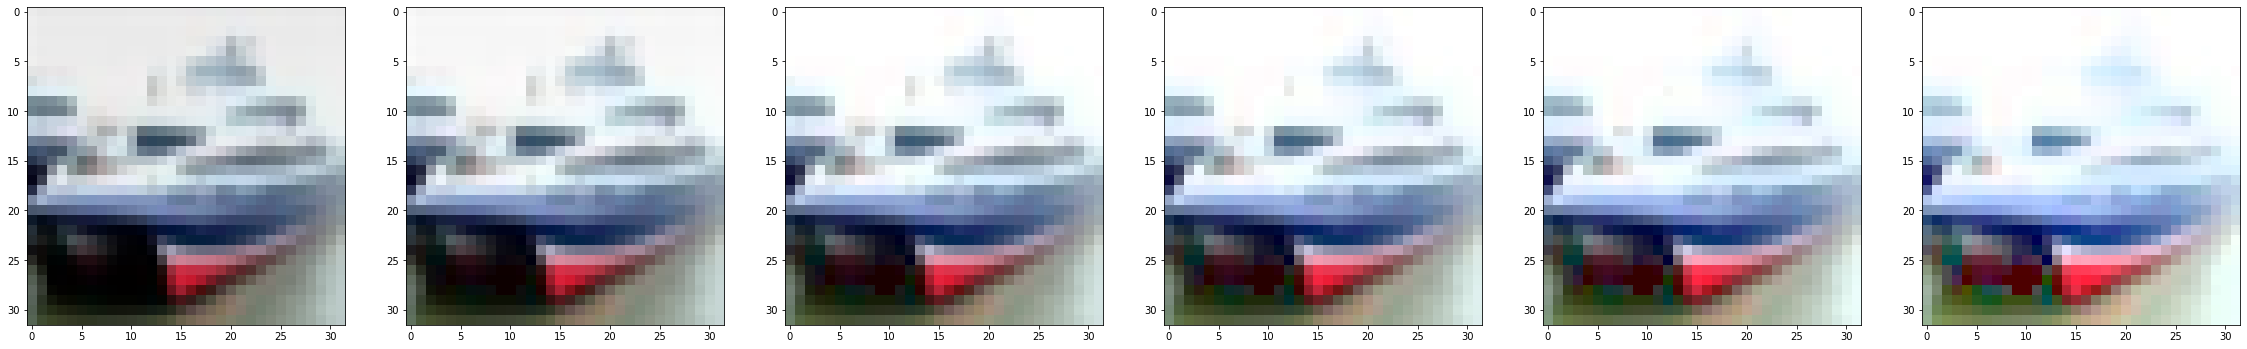

In [12]:
A=1
B=60000
x=0

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(32, 32))
fig.tight_layout(pad=3.0)

for i in range(A, A+B, 10000): 
    
    print(f'label={labels[i]}, sev={sev[i]}')
    axes[x].imshow(data[i])
#     axes[x].title.set_text(f'sev={sev[i]}')
#     ax.set_title(f'sev={sev[i]}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#     axes.set_fontsize(20)

    x+=1
#     plt.show()
    

In [6]:
model = load_cifar_model() 

In [7]:
acc_fn = keras.metrics.SparseCategoricalAccuracy()
ece = ExpectedCalibrationError()

In [9]:
acc = []
ece = []

acc_fn = keras.metrics.Accuracy()
ECE = ExpectedCalibrationError()

for sev in data_by_sev.keys(): 
    data_s, labels_s = data_by_sev[sev]


    preds = model.predict(data_s)
    acc.append(acc_fn(labels_s, tf.argmax(preds, axis=1)))
    ece.append(ECE.call(labels_s, preds))
    print(f" acc = {acc[-1]}")
    print(f" ece = {ece[-1]}")


 acc = 0.11760000139474869
 ece = 0.018676642328500748
 acc = 0.11675000190734863
 ece = 0.015055540949106216
 acc = 0.11616666615009308
 ece = 0.01625768654048443
 acc = 0.11572500318288803
 ece = 0.01676667481660843
 acc = 0.11537999659776688
 ece = 0.019660508260130882
 acc = 0.11490000039339066
 ece = 0.019613556563854218


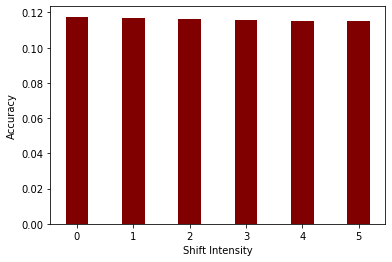

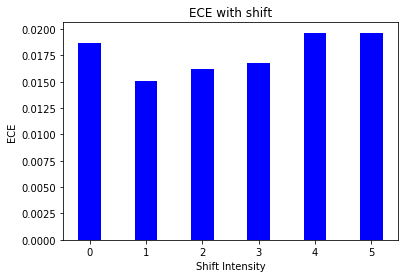

In [11]:


### Bar plots of a fixed model 
plt.bar(range(0, 6), acc, color ='maroon',
        width = 0.4)
 
plt.xlabel("Shift Intensity")
plt.ylabel("Accuracy")
plt.show()

plt.bar(range(0, 6), ece, color ='blue',
        width = 0.4)
 
plt.xlabel("Shift Intensity")
plt.ylabel("ECE")
plt.title("ECE with shift")
plt.show()

# for sev in range(5): 
    
#     print(f'label={labels[i]}, sev={sev[i]}')
#     axes[x].imshow(data[i])
#     axes[x].title.set_text(f'sev={sev[i]}')
#     ax.set_title(f'sev={sev[i]}', fontdict={'fontsize': 15, 'fontweight': 'medium'})
#     axes.set_fontsize(20)

#     x+=1
#     plt.show()

In [ ]:
### line plots to compare for fixed model
# plt.bar(range(1, 6), acc, color ='maroon',
x = range(6)

#test arrays for graphing while waiting for results
acc = [1 - (x_v/10) for x_v in x]
ece = [(x_v/10) for x_v in x]
ece2 = [(x_v/10)+.1 for x_v in x]

fig = plt.figure()
ax = plt.axes()
ax.plot(x, ece2, color='green', label='no calibration')
ax.plot(x, ece, color='blue', label='cal on train')
ax.plot(x, acc,color='red', label='cal on shifted')
plt.xlabel("Shift Intensity")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Results of different calibration methods")
plt.show()


